<a href="https://colab.research.google.com/github/dmar10862/uoc_tipologia_y_ciclo_de_vida_de_los_datos_practica_2/blob/develop/src/UOC_M2851_DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Practica 2: Limpieza y análisis de datos**

M2851 - Tipología y ciclo de vida de los datos

Ciencia de Datos

**David Marín Sánchez**

Junio 2020

# Descripción y referencias

En esta práctica se ha tratado de resolver el problema planeado en la competición de Kaggle [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview).

Para resolverla se han utilizado metodos o aprovechado algunas de las ideas planteadas en las siguientes referencias:

https://www.kaggle.com/ouyangg/titanic

https://www.kaggle.com/parthsuresh/binary-classifier-using-keras-97-98-accuracy

https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

https://github.com/Kaggle/kaggle-api

https://scikit-learn.org/stable/modules/impute.html

https://scikit-learn.org/dev/modules/generated/sklearn.impute.KNNImputer.html

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://scikit-learn.org/stable/modules/neural_networks_supervised.html#mlp-tips

https://nextjournal.com/schmudde/how-to-remove-outliers-in-data

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.bar.html

https://seaborn.pydata.org/examples/many_pairwise_correlations.html


# Hyperparametros


In [0]:
# Limpieza de datos
# Proporción de outliers a eliminar (a partir de los cuantiles)
remove_outilers_quantile = 0.15
# Número de categorias en las que agrupar la variable 'age'
age_categories = 10
# Número de categorias en las que agrupar la variable 'fare'
fare_categories = 10
# Dimensiones a eliminar después del análisis PCA
dimensions_to_remove = 0

# Modelado
# Número de neuronas de la capa oculta
neurons = 32
# Ratio de aprendizaje
lr = 0.0002
# Épocas o repeticiones del proceso de entrenamiento de la red neuronal
epochs = 200
# Muestras a procesar en cada paso de entrenamiento
batch_size = 1
# Pacieiencia o número de épocas en las que se permite que el que el error obtenido 
# supere al anterior error antes de parar el proceso de entrenamiento
patience = 10

# Librerias

In [2]:
from google.colab import drive
from google.colab import auth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy import stats
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Descargar dataset de Kaggle

In [3]:
# Montar Google Drive para poder recuperar las credenciales de Kaggle
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%%bash
# Instalar kaggle
pip install -q kaggle

# Cargar las credeciales de Kaggle de Google Drive
mkdir -p /root/.kaggle
cp -a "/content/drive/My Drive/Credentials/kaggle.json" /root/.kaggle/kaggle.json
ls -l /root/.kaggle

total 4
-rw------- 1 root root 64 May  9 08:42 kaggle.json


In [5]:
# Descargar dataset de Kaggle
%%bash
mkdir -p datasets
cd datasets
kaggle competitions download -c titanic
ls -la

gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
total 100
drwxr-xr-x 2 root root  4096 May 24 13:37 .
drwxr-xr-x 1 root root  4096 May 24 15:36 ..
-rw-r--r-- 1 root root  3258 May 24 13:37 gender_submission.csv
-rw-r--r-- 1 root root 28629 May 24 13:37 test.csv
-rw-r--r-- 1 root root 61194 May 24 13:37 train.csv


# Cargar Datos

In [0]:
# Se carga el dataset de entrenamiento como un DataFrame de Pandas
df_train = pd.read_csv('datasets/train.csv', index_col = 'PassengerId') 

In [0]:
# Se separan las caracteristicas de la variable objetivo ('Survived')
X_train = df_train.copy()
y_train = X_train[['Survived']]
X_train = X_train.drop(columns=['Survived'])

In [8]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 76.6+ KB


None

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
# Se muestra la variable objetivo para el DataFrame de entremanieto
display(y_train.info())
display(y_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  891 non-null    int64
dtypes: int64(1)
memory usage: 13.9 KB


None

,Survived
PassengerId,
1,0
2,1
3,1
4,1
5,0


In [0]:
# Se carga el dataset de test en un DataFrame de Pandas
df_test = pd.read_csv('datasets/test.csv', index_col='PassengerId') 
X_test = df_test.copy()

In [11]:
# Se muestran las características del DataFrame de test
display(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


None

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Limpieza de datos

## Extraer nuevas carcaterísticas

In [0]:
# Se define una función para convertir una variable a categórica
def factorize_feature(X, feature):
  # Se convierte la característica en un variable categórica
  # identificada con un número entero
  X[feature], _list = pd.factorize(X[feature])

  # No interesa imputar los posibles valores perdidos con el valor -1,
  # por lo que se subtituye el valor -1 por NaN
  X_train[feature] = X[feature].replace(-1, np.nan)

  # Se define un diccionario con el identificador de la categoria y su valor
  _dict = {k:int(v) for v, k in enumerate(_list)}
  print(_dict)

  # Se devuelve el diccionario
  return X, _dict

In [13]:
# Para el DataFrame de entrenamiento
# Se genera una nueva característica 'Title' a partir de la extracción 
# de parte de los caractéres de la característica 'Name'
X_train['Title'] = X_train['Name'].str.extract('([A-Za-z]+)\.')

# Se convierte la características 'Title'
# en variables categóricas identificada con un número entero
X_train, title = factorize_feature(X_train, 'Title')

{'Mr': 0, 'Mrs': 1, 'Miss': 2, 'Master': 3, 'Don': 4, 'Rev': 5, 'Dr': 6, 'Mme': 7, 'Ms': 8, 'Major': 9, 'Lady': 10, 'Sir': 11, 'Mlle': 12, 'Col': 13, 'Capt': 14, 'Countess': 15, 'Jonkheer': 16}


In [14]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
 10  Title     891 non-null    int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


None

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [0]:
# Para el DataFrame de test
# Se genera una nueva característica 'Title' a partir de la extracción 
X_test['Title'] = X_test['Name'].str.extract('([A-Za-z]+)\.')

# Se convierte la característica 'Title' en un variable categórica
# utilizando las categorías de la variable 'Title' del DataFrame de entrenamiento,
# a partir del diccionario generado
X_test['Title'] = X_test['Title'].map(title)

In [16]:
# Se muestran las características del DataFrame de test
display(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
 10  Title     417 non-null    float64
dtypes: float64(3), int64(3), object(5)
memory usage: 39.2+ KB


None

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1.0
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1.0


## Eliminación de características

In [17]:
# Se eliminan del DataFrame de entrenamiento las características que no son necesarias
X_train = X_train.drop(columns=['Name', 'Ticket', 'Cabin'])

# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
 7   Title     891 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


None

In [18]:
# Se eliminan del DataFrame de test las características que no son necesarias
X_test = X_test.drop(columns=['Name', 'Ticket', 'Cabin'])

# Se muestran las características del DataFrame de test
display(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
 7   Title     417 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 29.4+ KB


None

## Factorizar características

In [19]:
# Para el DataFrame de entrenamiento
# Se convierten las características 'Sex' y 'Embarked' 
# en variables categóricas
X_train, sex = factorize_feature(X_train, 'Sex')
X_train, embarked = factorize_feature(X_train, 'Embarked')

{'male': 0, 'female': 1}
{'S': 0, 'C': 1, 'Q': 2}


In [20]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    float64
 7   Title     891 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 62.6 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
1,3,0,22.0,1,0,7.2500,0.0,0
2,1,1,38.0,1,0,71.2833,1.0,1
3,3,1,26.0,0,0,7.9250,0.0,2
4,1,1,35.0,1,0,53.1000,0.0,1
5,3,0,35.0,0,0,8.0500,0.0,0


In [0]:
# Para el DataFrame de test
# Se convierten las características 'Sex' y 'Embarked' en un variables categóricas
# utilizando las categorías de las variables 'Sex' y 'Embarked' del DataFrame 
# de entrenamiento, a partir del diccionario generado
X_test['Sex'] = X_test['Sex'].map(sex)
X_test['Embarked'] = X_test['Embarked'].map(embarked)

In [22]:
# Se muestran las características del DataFrame de test
display(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    int64  
 7   Title     417 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 29.4 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
892,3,0,34.5,0,0,7.8292,2,0.0
893,3,1,47.0,1,0,7.0000,0,1.0
894,2,0,62.0,0,0,9.6875,2,0.0
895,3,0,27.0,0,0,8.6625,0,0.0
896,3,1,22.0,1,1,12.2875,0,1.0


## Valores extremos

In [0]:
# Se define una función para elminar valores extremos
def remove_outliers(X, feature, qmin, qmax):
  X.loc[~X[feature].between(qmin, qmax), feature] = np.nan
  return X

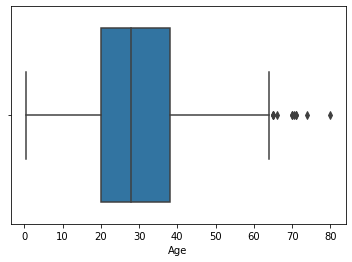

In [24]:
# El análisis de outliers solo tiene sentido para variables continuas
# Se muestra una boxplot de la variable 'Age' para el DataFrame de entrenamiento
plot = sns.boxplot(X_train['Age']);

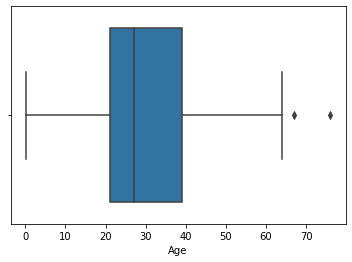

In [25]:
# Se muestra una boxplot de la variable 'Age' para el DataFrame de test
plot = sns.boxplot(X_test['Age']);

In [0]:
if remove_outilers_quantile > 0:
  # Se eliminan/reduce el número de los valore extremos
  qmin = X_train['Age'].quantile(remove_outilers_quantile)
  qmax = X_train['Age'].quantile(1 - remove_outilers_quantile)
  X_train = remove_outliers(X_train, 'Age', qmin, qmax)
  X_test = remove_outliers(X_test, 'Age', qmin, qmax)

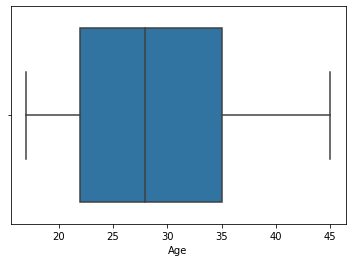

In [27]:
if remove_outilers_quantile > 0:
  # Se muestra una boxplot de la variable 'Age' para el DataFrame de entrenamiento
  plot = sns.boxplot(X_train['Age']);

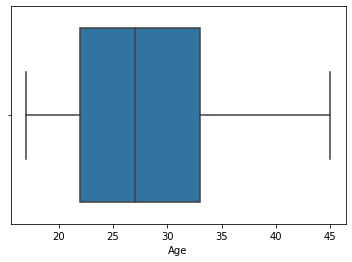

In [28]:
if remove_outilers_quantile > 0:
  # Se muestra una boxplot de la variable 'SibSp' para el DataFrame de test
  plot = sns.boxplot(X_test['Age']);

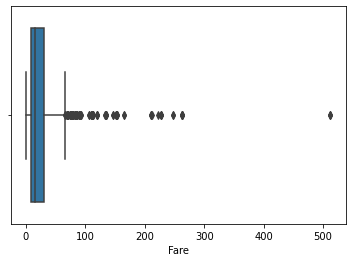

In [29]:
# Se muestra una boxplot de la variable 'SibSp' para el DataFrame de entrenamiento
plot = sns.boxplot(X_train['Fare']);

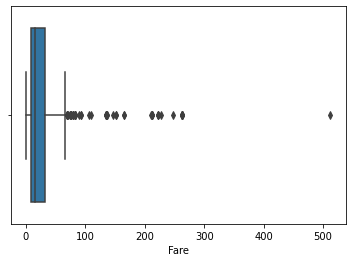

In [30]:
# Se muestra una boxplot de la variable 'SibSp' para el DataFrame de test
plot = sns.boxplot(X_test['Fare']);

In [0]:
if remove_outilers_quantile > 0:
  qmin = X_train['Fare'].quantile(remove_outilers_quantile)
  qmax = X_train['Fare'].quantile(1 - remove_outilers_quantile)
  X_train = remove_outliers(X_train, 'Fare', qmin, qmax)
  X_test = remove_outliers(X_test, 'Fare', qmin, qmax)

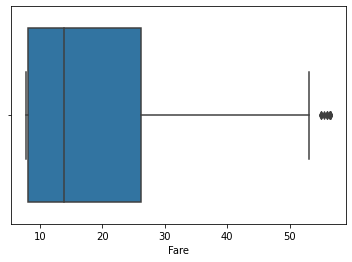

In [32]:
if remove_outilers_quantile > 0:
  # Se muestra una boxplot de la variable 'Parch' para el DataFrame de entrenamiento
  plot = sns.boxplot(X_train['Fare']);

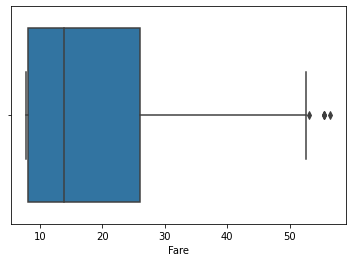

In [33]:
if remove_outilers_quantile > 0:
  # Se muestra una boxplot de la variable 'Parch' para el DataFrame de test
  plot = sns.boxplot(X_test['Fare']);

In [34]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       511 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      656 non-null    float64
 6   Embarked  889 non-null    float64
 7   Title     891 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 62.6 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
1,3,0,22.0,1,0,NaN,0.0,0
2,1,1,38.0,1,0,NaN,1.0,1
3,3,1,26.0,0,0,7.925,0.0,2
4,1,1,35.0,1,0,53.100,0.0,1
5,3,0,35.0,0,0,8.050,0.0,0


In [35]:
# Se muestran las características del DataFrame de test
display(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       246 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      299 non-null    float64
 6   Embarked  418 non-null    int64  
 7   Title     417 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 29.4 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
892,3,0,34.5,0,0,7.8292,2,0.0
893,3,1,NaN,1,0,NaN,0,1.0
894,2,0,NaN,0,0,9.6875,2,0.0
895,3,0,27.0,0,0,8.6625,0,0.0
896,3,1,22.0,1,1,12.2875,0,1.0


## Discretizar características

In [0]:
# Se define una función para convertir en categórica
# una característica a partir de un diccionario con
# el que mapear las categorías
def map_discrete_categories(X, feature, _dict):
  _list = []
  for i, x in enumerate(list(X[feature])):
    found = False
    for k, v in _dict.items():
      try:
        if x in k:
          _list.append(v)
          found = True
          break
      except:
        pass
    if not found:
      _list.append(np.nan)
  X[feature] = _list
  return X

In [37]:
# Siempre que se decida discretizar la variable 'Age'
if age_categories > 0:
  # Se agrupan las muestras en categorías con el mismo número de muestras
  # El número de categorías viene definido por la variable 'age_categories'
  X_train['Age'] = pd.qcut(X_train['Age'], age_categories)

  # Se convierte la característica 'Age' en una variable categórica
  X_train, age = factorize_feature(X_train, 'Age')

{Interval(21.0, 24.0, closed='right'): 0, Interval(36.0, 40.0, closed='right'): 1, Interval(24.0, 26.0, closed='right'): 2, Interval(33.0, 36.0, closed='right'): 3, Interval(26.0, 28.0, closed='right'): 4, Interval(19.0, 21.0, closed='right'): 5, Interval(30.0, 33.0, closed='right'): 6, Interval(16.999, 19.0, closed='right'): 7, Interval(40.0, 45.0, closed='right'): 8, Interval(28.0, 30.0, closed='right'): 9}


In [38]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       511 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      656 non-null    float64
 6   Embarked  889 non-null    float64
 7   Title     891 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 62.6 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
1,3,0,0.0,1,0,NaN,0.0,0
2,1,1,1.0,1,0,NaN,1.0,1
3,3,1,2.0,0,0,7.925,0.0,2
4,1,1,3.0,1,0,53.100,0.0,1
5,3,0,3.0,0,0,8.050,0.0,0


In [0]:
# Siempre que se decida discretizar la variable 'Age'
if age_categories > 0:
  # Se asigna cada valor de la variable 'Age' del 
  # DataFrame de test al identificador numérico de 
  # la categoría que le corresponde, utilizando las categorías
  # de la variable 'Age' del DataFrame de entrenamiento
  map_discrete_categories(X_test, 'Age', age)

In [40]:
# Se muestran las características del DataFrame de test
display(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       246 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      299 non-null    float64
 6   Embarked  418 non-null    int64  
 7   Title     417 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 29.4 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
892,3,0,3.0,0,0,7.8292,2,0.0
893,3,1,NaN,1,0,NaN,0,1.0
894,2,0,NaN,0,0,9.6875,2,0.0
895,3,0,4.0,0,0,8.6625,0,0.0
896,3,1,0.0,1,1,12.2875,0,1.0


In [41]:
if fare_categories > 0:
  # Se agrupa las muestras en categorías con el mismo número de muestras
  # El número de categorías viene definido por la variable 'fare_categories'
  X_train['Fare'] = pd.qcut(X_train['Fare'], fare_categories)

  # Se convierte la características 'Age' en una variable categórica
  X_train, fare = factorize_feature(X_train, 'Fare')

{Interval(7.854, 7.925, closed='right'): 0, Interval(35.5, 56.496, closed='right'): 1, Interval(7.925, 8.662, closed='right'): 2, Interval(18.0, 25.965, closed='right'): 3, Interval(8.662, 11.242, closed='right'): 4, Interval(27.75, 35.5, closed='right'): 5, Interval(13.825, 18.0, closed='right'): 6, Interval(25.965, 27.75, closed='right'): 7, Interval(7.749, 7.854, closed='right'): 8, Interval(11.242, 13.825, closed='right'): 9}


In [42]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       511 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      656 non-null    float64
 6   Embarked  889 non-null    float64
 7   Title     891 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 62.6 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
1,3,0,0.0,1,0,NaN,0.0,0
2,1,1,1.0,1,0,NaN,1.0,1
3,3,1,2.0,0,0,0.0,0.0,2
4,1,1,3.0,1,0,1.0,0.0,1
5,3,0,3.0,0,0,2.0,0.0,0


In [0]:
# Siempre que se decida discretizar la variable 'Fare'
if fare_categories > 0:
  # Se asigna cada valor de la variable 'Fare' del 
  # DataFrame de test al identificador numérico de 
  # la categoría que le corresponde, utilizando las categorías
  # de la variable 'Age' del DataFrame de entrenamiento
  map_discrete_categories(X_test, 'Fare', fare)

In [44]:
# Se muestran las características del DataFrame de test
display(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       246 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      299 non-null    float64
 6   Embarked  418 non-null    int64  
 7   Title     417 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 29.4 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
892,3,0,3.0,0,0,8.0,2,0.0
893,3,1,NaN,1,0,NaN,0,1.0
894,2,0,NaN,0,0,4.0,2,0.0
895,3,0,4.0,0,0,4.0,0,0.0
896,3,1,0.0,1,1,9.0,0,1.0


## Valores perdidos

In [0]:
# Se imputan los valores perdidos (o eliminados) utilizndo el método k-Nearest Neighbors
imp = KNNImputer().fit(X_train)
X_train = pd.DataFrame(imp.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns = X_test.columns)

In [46]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    float64
 1   Sex       891 non-null    float64
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    float64
 4   Parch     891 non-null    float64
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    float64
 7   Title     891 non-null    float64
dtypes: float64(8)
memory usage: 55.8 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3.0,0.0,0.0,1.0,0.0,4.4,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,2.6,1.0,1.0
2,3.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0
3,1.0,1.0,3.0,1.0,0.0,1.0,0.0,1.0
4,3.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0


In [47]:
# Se muestran las características del DataFrame de test
display(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    float64
 1   Sex       418 non-null    float64
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    float64
 4   Parch     418 non-null    float64
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    float64
 7   Title     418 non-null    float64
dtypes: float64(8)
memory usage: 26.2 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3.0,0.0,3.0,0.0,0.0,8.0,2.0,0.0
1,3.0,1.0,2.4,1.0,0.0,5.6,0.0,1.0
2,2.0,0.0,4.6,0.0,0.0,4.0,2.0,0.0
3,3.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0
4,3.0,1.0,0.0,1.0,1.0,9.0,0.0,1.0


## Reducción la dimensionalidad

Proporción de la variabilidad explicada por elos componentes: 
{0: 0.390701, 1: 0.292593, 2: 0.160694, 3: 0.067522, 4: 0.034344, 5: 0.024856, 6: 0.020086, 7: 0.009203}


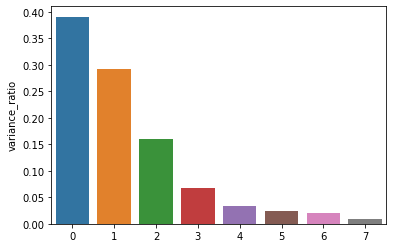

In [48]:
# Se aplica un análisis de componentes principales
# para indentificar las componentes mas información aportan
# en el espacio de características
pca = PCA(n_components = len(X_train.columns)).fit(X_train)
_dict = {k:round(v, 6) for k, v in enumerate(pca.explained_variance_ratio_)}

# Proporción de la variabilidad explicada por las componentes
print('Proporción de la variabilidad explicada por elos componentes: \n' +
      str(_dict))

# Representación gráfica de la proporción de la variabilidad explicada
# por cada una de las componentes
data = pd.DataFrame.from_dict(_dict, orient='index', columns = ['variance_ratio'] )
plot = sns.barplot(x=data.index, y='variance_ratio', data = data)

In [0]:
if dimensions_to_remove > 0:
  pca = PCA(n_components = len(X_train.columns) - dimensions_to_remove).fit(X_train)
  X_train = pd.DataFrame(pca.transform(X_train))
  X_test = pd.DataFrame(pca.transform(X_test))

In [0]:
if dimensions_to_remove > 0:
  # Se muestran las características del DataFrame de entrenamiento
  display(X_train.info())
  display(X_train.head())

In [0]:
if dimensions_to_remove > 0:
  # Se muestran las características del DataFrame de test
  display(X_train.info())
  display(X_train.head())

## Estandarización

In [0]:
# Se realiza una estandarización del cojunto de características,
# de manera qu todas las características se ponderen igual en
# los modelos que se implementaran en los siguientes puntos.
# Esto es importante para implementar el modelo
# de red neuronal porque es especialmenete sensible al escalado
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [53]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    float64
 1   Sex       891 non-null    float64
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    float64
 4   Parch     891 non-null    float64
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    float64
 7   Title     891 non-null    float64
dtypes: float64(8)
memory usage: 55.8 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0.827377,-0.737695,-1.787905,0.432793,-0.473674,-0.014208,-0.570766,-0.542822
1,-1.566107,1.355574,-1.373595,0.432793,-0.473674,-0.692374,1.003699,0.037099
2,0.827377,1.355574,-0.959285,-0.474545,-0.473674,-1.671948,-0.570766,0.617020
3,-1.566107,1.355574,-0.544974,0.432793,-0.473674,-1.295189,-0.570766,0.037099
4,0.827377,-0.737695,-0.544974,-0.474545,-0.473674,-0.918430,-0.570766,-0.542822


In [54]:
# Se muestran las características del DataFrame de test
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    float64
 1   Sex       891 non-null    float64
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    float64
 4   Parch     891 non-null    float64
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    float64
 7   Title     891 non-null    float64
dtypes: float64(8)
memory usage: 55.8 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0.827377,-0.737695,-1.787905,0.432793,-0.473674,-0.014208,-0.570766,-0.542822
1,-1.566107,1.355574,-1.373595,0.432793,-0.473674,-0.692374,1.003699,0.037099
2,0.827377,1.355574,-0.959285,-0.474545,-0.473674,-1.671948,-0.570766,0.617020
3,-1.566107,1.355574,-0.544974,0.432793,-0.473674,-1.295189,-0.570766,0.037099
4,0.827377,-0.737695,-0.544974,-0.474545,-0.473674,-0.918430,-0.570766,-0.542822


# Análisis

## Análisis estadístico descriptivo

In [55]:
# Estadísticas del DataFrame de entrenamiento
display(X_train.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02
mean,-2.031048e-16,3.162453e-16,1.080318e-16,3.456519e-16,6.716164e-17,2.791133e-17,-6.230208e-17,2.367479e-17
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00
min,-1.566107e+00,-7.376951e-01,-1.787905e+00,-4.745452e-01,-4.736736e-01,-1.671948e+00,-5.707655e-01,-5.428218e-01
25%,-3.693648e-01,-7.376951e-01,-6.278361e-01,-4.745452e-01,-4.736736e-01,-9.184295e-01,-5.707655e-01,-5.428218e-01
50%,8.273772e-01,-7.376951e-01,-4.780148e-02,-4.745452e-01,-4.736736e-01,-8.955957e-02,-5.707655e-01,-5.428218e-01
75%,8.273772e-01,1.355574e+00,6.979574e-01,4.327934e-01,-4.736736e-01,8.146622e-01,1.003699e+00,6.170204e-01
max,8.273772e-01,1.355574e+00,1.940889e+00,6.784163e+00,6.974147e+00,1.718884e+00,2.578164e+00,8.735916e+00


In [56]:
# Estadísticas del DataFrame test
display(X_test.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,-0.051570,0.023493,-0.000027,-0.068631,0.013345,0.027434,0.159967,-0.067231
std,1.007462,1.008165,1.058201,0.813665,1.218251,1.017912,1.079321,0.794717
min,-1.566107,-0.737695,-1.787905,-0.474545,-0.473674,-1.671948,-0.570766,-0.542822
25%,-1.566107,-0.737695,-0.793560,-0.474545,-0.473674,-0.843078,-0.570766,-0.542822
50%,0.827377,-0.737695,0.035061,-0.474545,-0.473674,-0.051884,-0.570766,-0.542822
75%,0.827377,1.355574,0.697957,0.432793,-0.473674,0.965366,1.003699,0.588024
max,0.827377,1.355574,1.940889,6.784163,10.698058,1.718884,2.578164,6.996152


## Análisis estadístico inferencial

### Análisis de normalidad y homocedasticidad

In [0]:
# Se define una función para realizar el análisis de normalidad
def normality_test(X, variable):
  # Se aplica el test Shapiro-Wilk para la variable
  statistic, pvalue = stats.shapiro(X[variable])
  statistic = round(statistic, 6)
  pvalue = round(pvalue, 6)
  print('statistic = '+str(statistic))
  print('pvalue = '+str(pvalue))

  if pvalue < 0.05:
    print("La distribución no se ajusta a una distribución normal")
  if pvalue > 0.05:
    print("La distribución se ajusta a una distribución normal")
    
  # Se muestra el histograma de la variable
  plot = sns.distplot(X[variable]);

In [0]:
# Se define una función para realizar el análisis de homocedasticidad
def homoscedasticity_test(X, variable):
  # Se aplica el test Fligner-Killeen para la variable y según si la persona sobrevivió o no
  statistic, pvalue = stats.fligner(X[X['Survived'] == 0][variable], X[X['Survived'] == 1][variable])
  statistic = round(statistic, 6)
  pvalue = round(pvalue, 6)
  print('statistic = '+str(statistic))
  print('pvalue = '+str(pvalue))

  if pvalue < 0.05:
    print("Las varianzas son significativamente difernetes")
  else:
    print("Las varianzas no son significativamente difernetes")

  # Se muestran los histogramas de la variable según si la persona sobrevivió o no
  plot = sns.catplot(x = variable, kind = "box", row = 'Survived', height = 4, data = X)

In [0]:
# Se vuelven a unir las características con la clase a predecir
# para poder aplicar los tests
Xy_train = X_train.copy()
Xy_train['Survived'] = y_train

In [60]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title'], dtype='object')

statistic = 0.972815
pvalue = 0.0
La distribución no se ajusta a una distribución normal


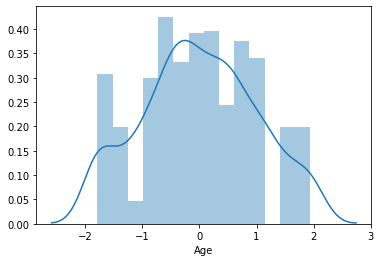

In [61]:
normality_test(Xy_train, 'Age')

statistic = 0.31684
pvalue = 0.573513
Las varianzas no son significativamente difernetes


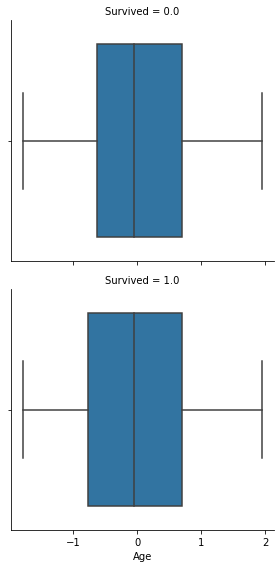

In [62]:
homoscedasticity_test(Xy_train, 'Age')

statistic = 0.955148
pvalue = 0.0
La distribución no se ajusta a una distribución normal


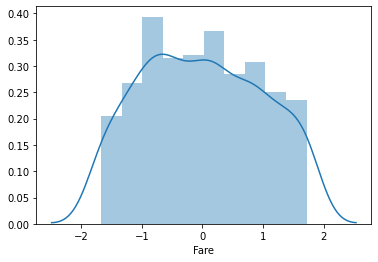

In [63]:
normality_test(Xy_train, 'Fare')

statistic = 0.239168
pvalue = 0.624807
Las varianzas no son significativamente difernetes


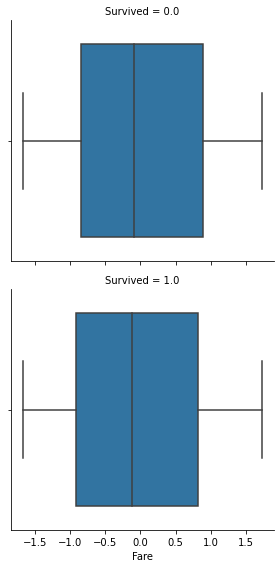

In [64]:
homoscedasticity_test(Xy_train, 'Fare')

### Análisis de correlación y regresión lineal

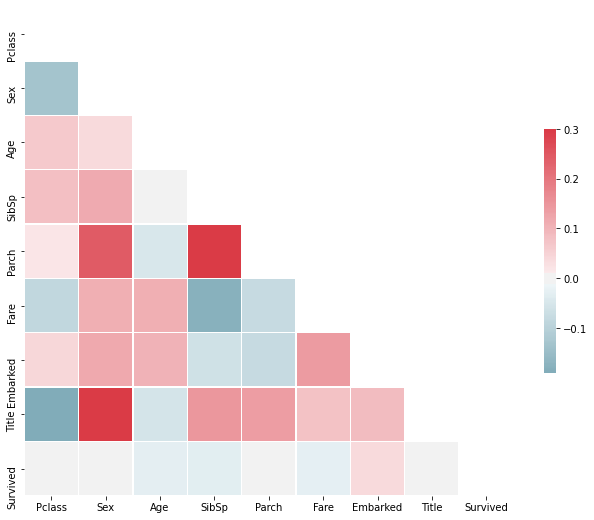

In [65]:
# Compute the correlation matrix
corr = Xy_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [66]:
model = sm.OLS(y_train.values.ravel(), X_train).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.235
Model:                            OLS   Adj. R-squared (uncentered):              0.228
Method:                 Least Squares   F-statistic:                              33.96
Date:                Sun, 24 May 2020   Prob (F-statistic):                    7.17e-47
Time:                        16:03:01   Log-Likelihood:                         -718.19
No. Observations:                 891   AIC:                                      1452.
Df Residuals:                     883   BIC:                                      1491.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Pclass        -0.1258      0.019     -6.664      0.000      -0.163      -0.089
Sex            0.2388      0.020     11.740      0.000       0.199       0.279
Age            0.0048      0.019      0.259      0.796      -0.032       0.041
SibSp         -0.0396      0.021     -1.925      0.055      -0.080       0.001
Parch         -0.0044      0.021     -0.215      0.830      -0.045       0.036
Fare          -0.0195      0.019     -1.028      0.304      -0.057       0.018
Embarked       0.0263      0.019      1.400      0.162      -0.011       0.063
Title          0.0368      0.020      1.831      0.067      -0.003       0.076
==============================================================================
Omnibus:                       39.513   Durbin-Watson:                   0.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.876
Skew:                           0.542   Prob(JB):                     2.97e-10
Kurtosis:                       3.083   Cond. No.                         1.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Análisis de Regresion

In [67]:
# Se genera un modelo de regresión logística a partir del subconjunto de 
# datos de entrenamiento
clf = LogisticRegression(solver = 'lbfgs')
clf.fit(X_train, y_train.values.ravel())

# Se valida el modelo comparando las predicciones realizadas a partir
# del subconjunto de datos de validación con los valores reales
y_pred = clf.predict(X_train)

train_acc = round(accuracy_score(y_train, y_pred, normalize=True),6)
cmatrix_train = confusion_matrix(y_train, y_pred)

print('Matriz de confusión del modelo:\n', cmatrix_train)
print('Precisión del modelo:', train_acc)

Matriz de confusión del modelo:
 [[479  70]
 [109 233]]
Precisión del modelo: 0.799102


## Aprendizaje automático

In [0]:
# ML Model train
def train_ml_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, patience, shuffle=True):
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=shuffle, callbacks=[es, mc])

    # load the saved model
    model = load_model('best_model.h5')

    # plot training history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()
  
    # Estimate model performance
    trainScore = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
    valScore = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
  
    print('Train Loss: %.6f' % trainScore[0])
    print('Train Accuracy: %.6f' % trainScore[1])
    print('Val Loss: %.6f' % valScore[0])
    print('Val Accuracy: %.6f' % valScore[1])
  
    return model

In [0]:
# Entrenar Red neuronal densa
def dense_nn(X, y, epochs, batch_size, lr, patience, neurons, shuffle=True): 
  # Split test y val
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

  # Dimensiones
  n_input =  X_train.shape[1]
  n_output = y_train.shape[1]
  
  model = Sequential([
      Dense(n_input, input_dim=n_input, activation='relu'),
      Dense(neurons, activation='relu'),
      Dense(n_output, activation='sigmoid')
  ])
  
  model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

  model = train_ml_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, patience, shuffle)
  
  return model

In [0]:
# ML Model predict
def predict_with_ml_model(model, X, batch_size):
  y_pred = (model.predict(X, batch_size=batch_size) > 0.5).astype("int32")

  return y_pred

Epoch 1/200
801/801 [==============================] - 1s 2ms/step - loss: 0.6438 - accuracy: 0.6692 - val_loss: 0.6044 - val_accuracy: 0.7778
Epoch 2/200
801/801 [==============================] - 1s 1ms/step - loss: 0.5809 - accuracy: 0.7378 - val_loss: 0.5438 - val_accuracy: 0.7889
Epoch 3/200
801/801 [==============================] - 1s 1ms/step - loss: 0.5397 - accuracy: 0.7665 - val_loss: 0.5019 - val_accuracy: 0.8333
Epoch 4/200
801/801 [==============================] - 1s 1ms/step - loss: 0.5136 - accuracy: 0.7828 - val_loss: 0.4729 - val_accuracy: 0.8111
Epoch 5/200
801/801 [==============================] - 1s 1ms/step - loss: 0.4961 - accuracy: 0.7915 - val_loss: 0.4510 - val_accuracy: 0.8222
Epoch 6/200
801/801 [==============================] - 1s 1ms/step - loss: 0.4833 - accuracy: 0.7928 - val_loss: 0.4386 - val_accuracy: 0.8111
Epoch 7/200
801/801 [==============================] - 1s 1ms/step - loss: 0.4741 - accuracy: 0.7965 - val_loss: 0.4263 - val_accuracy: 0.8222

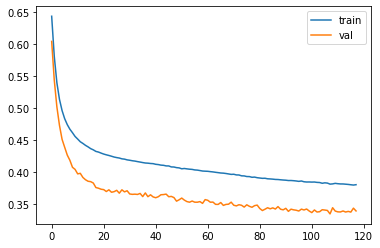

Train Loss: 0.379405
Train Accuracy: 0.846442
Val Loss: 0.334203
Val Accuracy: 0.833333


In [71]:
model = dense_nn(X_train, y_train, epochs=epochs, batch_size=batch_size, lr=lr, patience=patience, neurons=neurons)

In [72]:
# accuracy
y_pred = predict_with_ml_model(model, X_train, batch_size=batch_size)

train_acc = round(accuracy_score(y_train, y_pred, normalize=True),6)
cmatrix_train = confusion_matrix(y_train, y_pred)

print('Matriz de confusión del modelo:\n', cmatrix_train)
print('Precisión del modelo:', train_acc)

Matriz de confusión del modelo:
 [[510  39]
 [ 99 243]]
Precisión del modelo: 0.845118


In [73]:
# generate predictions for test
df_pred = pd.DataFrame(predict_with_ml_model(model, X_test, batch_size=batch_size), columns=['Survived'], index =  df_test.index)
  
display(df_pred.describe())
display(df_pred.head()) 
df_pred.to_csv('submission.csv', index=True)  

,Survived
count,418.000000
mean,0.356459
std,0.479527
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


# Subir resultados a Kaggle

In [75]:
%%bash
kaggle competitions submit -c titanic -f submission.csv -m "New submission test"

Successfully submitted to Titanic: Machine Learning from Disaster

100%|##########| 2.77k/2.77k [00:03<00:00, 881B/s]
